Models for Music to Score Alignment
====
Gabriel Huang, 
December 2015

<i>Project for Probabilistic Graphical Models Class - Master M2 MVA, ENS Cachan</i>

Todo
----
- New Melodies
- Varying Beats
- New Tempo Changes
- Fixed-tempo models with wrong assumption on tempo -> usefulness of adaptive tempo agent
- Pruning in HSMM recursion: effects
- Maybe add 3rd mode to HMM
- HSMM with HMM's implicit geometric duration model
- HSMM with fixed tempo
- Evaluate various Tempo Models
- Adaptive tempo agent (MAP)
- Adaptive linear tempo agent (Inference)
- Adaptive linear tempo agent (Inference through sampling)

Future Work
----
- Relation to (Extended) Kalman Filter
- Adaptive Observation model "temperature" (confidence on observation model)
- Model Tempo as random walk / gaussian process
- Implement Polyphony
- Evaluate on MIDI data, then real audio recordings
- Use Constant Q Transform Spectrum as features
- Expectation-Maximization to learn duration model
- Supervised learning to learn observation model, with prealigned data
- Jointly align audio recordings and learn (need a bunch of them)
- RNNS, LSTMS, GRUS
- CNN on CQT spectrum, as an image


Note to Pitch
----
<i>Courtesy of [MakeMusic](https://www.finalemusic.com) Finale User Manual</i> 

<img src="piano-roll-pitch.gif">

In [125]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import numbers
import pylab
from copy import deepcopy
%matplotlib inline
#pylab.rcParams['figure.figsize'] = (20.0, 8.0)  # set figure size
pylab.rcParams['figure.figsize'] = (10.0, 5.0)  # set figure size

FRAME_SEC=0.1
STD = 4.

Data Generation
----

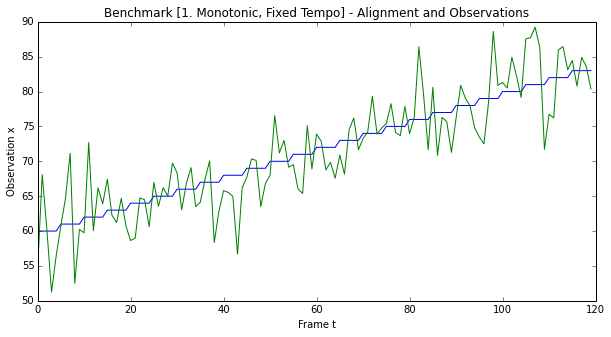

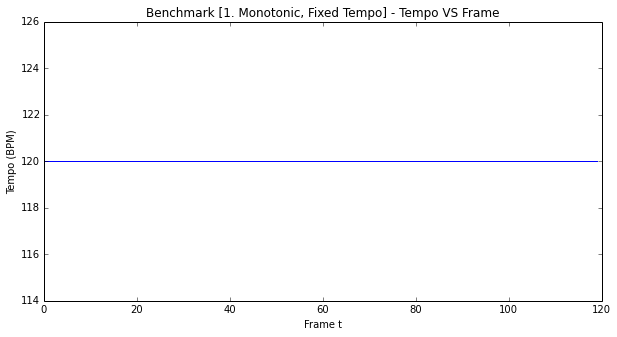

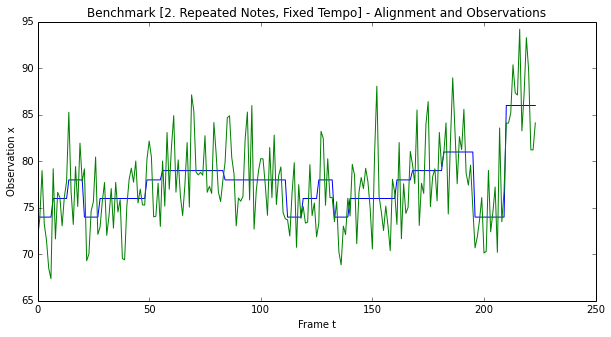

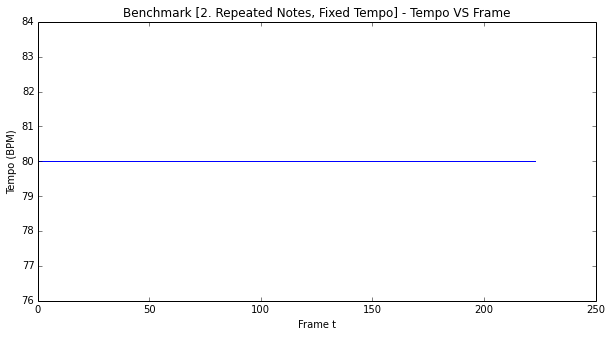

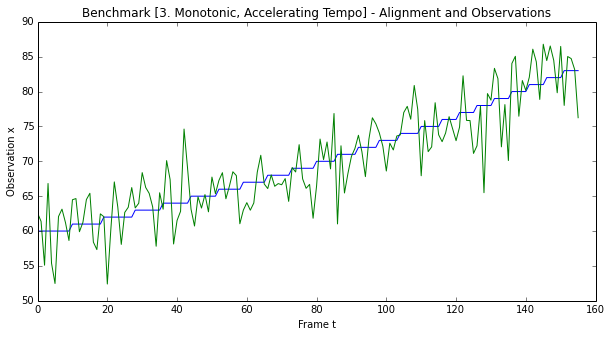

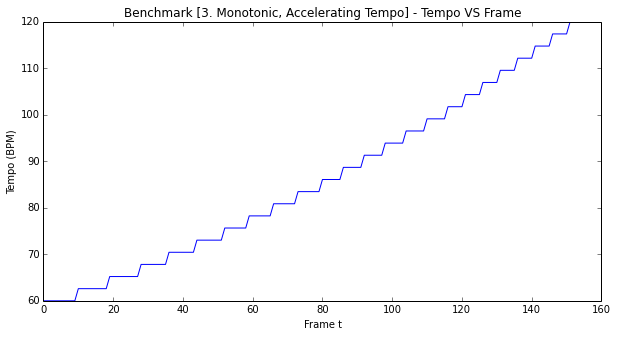

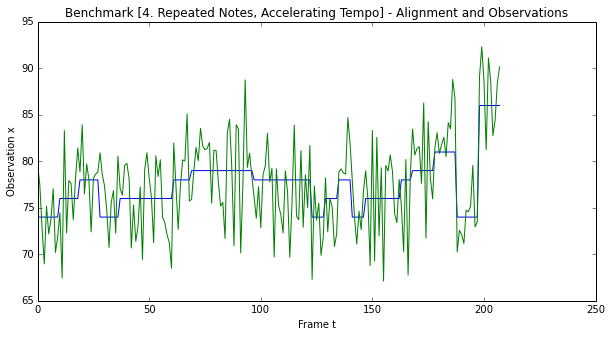

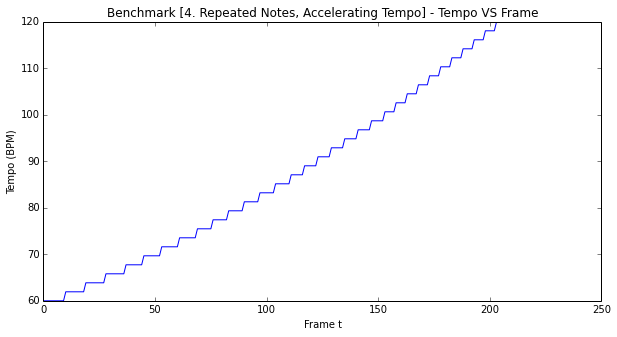

In [128]:
ABC_TO_PITCHES_TABLE = {'A': 0, 'B': 2, 'C':3, 'D': 5,
                        'E': 7, 'F': 8, 'G': 10,
                        'a': 12, 'b': 14, 'c': 15, 'd': 17,
                        'e': 19, 'f': 20, 'g': 22}
def abc_to_pitches(abc, octave=4):
    '''
    Convert string of notes to MIDI pitches
    '''
    pitches = []
    for note in abc:
        rel_pos = ABC_TO_PITCHES_TABLE[note]
        pitches.append(23 + 12 * octave + rel_pos)
    return np.asarray(pitches)


def get_alignment(durations, bpm, frame_sec):
    '''
    Parameters
    ----------
    durations : list of float
        duration of each note in beats (quarter notes)
    bpm : float or list of float
        tempo in beats per minute, at each note
    frame_sec : float, optional
        seconds per frame (default 0.1 seconds)
        
    Returns
    -------
    z : list of int
        alignment of 
        z[t] = j means that score event j is played at frame t (time t*frame_sec)
    realtime_bpm : list of float
        bpm at each frame
    '''
    if isinstance(bpm, numbers.Number):
        bpm = [bpm] * len(durations)
    z = []
    realtime_bpm = []
    for i, (duration, current_bpm) in enumerate(zip(durations, bpm)):
            beat_sec = 60. / current_bpm  # seconds per beat
            frames_per_beat = beat_sec / frame_sec
            realtime_duration = int(frames_per_beat * duration)
            z += [i] * realtime_duration
            realtime_bpm += [current_bpm] * realtime_duration
    return np.asarray(z), np.asarray(realtime_bpm)
    

def sample_gaussian_obs(pitches, z, std):
    '''
    Observations are unimodal Gaussians centered around pitch
    
    Parameters
    ----------
    pitches : list of int
        pitches of notes (following MIDI tables)
    '''
    x = pitches[z] + std * np.random.normal(size=len(z))
    return np.asarray(x)


class Benchmark(object):
    def __init__(self, pitches, durations, bpm, frame_sec, name='untitled'):
        self.pitches = pitches
        self.durations = durations
        self.events = zip(self.pitches, self.durations)
        self.bpm = bpm
        self.frame_sec = frame_sec
        self.name = name
        self.z, self.realtime_bpm = get_alignment(durations, bpm, frame_sec)
        
    def __repr__(self):
        l = ' '.join(map(str, zip(self.pitches, self.durations)))
        return str(l)
    
    def frames_per_beat(self):
        return 60. / (self.bpm * self.frame_sec)
    
        
class UnimodalGaussianBenchmark(Benchmark):
    def __init__(self, pitches, durations, bpm, frame_sec, std=STD, name='untitled'):
        Benchmark.__init__(self, pitches, durations, bpm, frame_sec, name=name)
        self.x = sample_gaussian_obs(pitches, self.z, std)

    def plot(self):
        plt.figure()
        plt.plot(self.pitches[self.z])
        plt.plot(self.x) 
        plt.title('Benchmark [{}] - Alignment and Observations'.format(self.name))
        plt.xlabel('Frame t')
        plt.ylabel('Observation x')
        plt.figure()
        plt.plot(self.realtime_bpm)
        plt.title('Benchmark [{}] - Tempo VS Frame'.format(self.name))
        plt.xlabel('Frame t')
        plt.ylabel('Tempo (BPM)')
               
        
# Benchmark 1: Quarter notes rising from C4 to C6, Constant TEMPO
pitches = np.arange(60, 84)
durations = np.ones(len(pitches))
bpm = 120

bench1 = UnimodalGaussianBenchmark(pitches, durations, bpm, FRAME_SEC, name='1. Monotonic, Fixed Tempo')
bench1.plot()

# Benchmark 2: Lots of repeated notes, constant TEMPO, but different
pitches = abc_to_pitches('CDECDDDEFFFFEEEECDECDDDEFFGGCCcc')
durations = np.ones(len(pitches))
bpm = 80

bench2 = UnimodalGaussianBenchmark(pitches, durations, bpm, FRAME_SEC, name='2. Repeated Notes, Fixed Tempo')
bench2.plot()

# Benchmark 3: Quarter notes rising from C4 to C6, Increasing TEMPO
pitches = np.arange(60, 84)
durations = np.ones(len(pitches))
bpm = np.linspace(60, 120, len(pitches))

bench3 = UnimodalGaussianBenchmark(pitches, durations, bpm, FRAME_SEC, name='3. Monotonic, Accelerating Tempo')
bench3.plot()

# Benchmark 4: Lots of repeated notes, Increasing TEMPO
pitches = abc_to_pitches('CDECDDDEFFFFEEEECDECDDDEFFGGCCcc')
durations = np.ones(len(pitches))
bpm = np.linspace(60, 120, len(pitches))

bench4 = UnimodalGaussianBenchmark(pitches, durations, bpm, FRAME_SEC, name='4. Repeated Notes, Accelerating Tempo')
bench4.plot()

In [150]:
def find_event_ends(predicted_z):
    diff = np.diff(predicted_z)
    assert(np.all(diff >= 0))  # can only move forward
    event_ends = []
    for t, d in enumerate(diff):
        # add all new event changes
        for i in xrange(d):
            new_event_idx = len(event_ends)
            event_ends.append(t)
    return event_ends        
            
'''
def evaluate_with_transitions(predicted_z, real_z, allow_missing=False):
    assert(len(predicted_z) == len(real_z))
    predicted_ends = find_event_ends(predicted_z)
    real_ends = find_event_ends(real_z)
    if len(real_ends) != len(predicted_ends):
        if allow_missing:
            predicted_ends += [len(real_z)] * (len(real_ends) - len(predicted_ends))
        else:
            raise Exception('Predicted Z does not go through all states')
    # Sum of absolute differences
    predicted_ends = np.asarray(predicted_ends)
    real_ends = np.asarray(real_ends)
    abs_diff = np.abs(predicted_ends - real_ends)
    return {'mean': np.mean(abs_diff), 
            'std': np.std(abs_diff),
            'max': np.max(abs_diff),
            '> 2 frame': np.mean(abs_diff > 2),
            '> 3 frame': np.mean(abs_diff > 3)}
'''

def evaluate(predicted_z, real_z, frame_sec):
    assert(len(predicted_z) == len(real_z))
    # Sum of absolute differences
    abs_diff = np.abs(predicted_z - real_z)
    sec_diff = frame_sec * abs_diff
    return {'mean': np.mean(sec_diff), 
            'std': np.std(sec_diff),
            'max': np.max(sec_diff),
            '> 100 ms': np.mean(sec_diff > 0.1),
            '> 1 s': np.mean(sec_diff > 1.)}

def plot_aligns(proposed, real):
    real_plot = plt.plot(np.arange(len(real)), real, label='Real Alignment')
    proposed_plot = plt.plot(np.arange(len(proposed)), proposed, label='Proposed Alignment')
    plt.title('Compared Alignments')
    plt.xlabel('frame t')
    plt.ylabel('event j')
    plt.legend()

In [130]:
class Distribution(object):
    def get_log_pdf(self, x):
        pass
    
    def get_pdf(self, x):
        return np.exp(self.get_log_prob(x))
    
    def __getitem__(self, x):
        return self.get_log_pdf(x)
    
    
class ObservationModel(Distribution): 
    pass
    
    
class DurationModel(ObservationModel):
    def get_log_survival(self, x):
        pass
    
    def get_survival(self, x):
        return np.exp(self.get_log_survival(x))
    

class UnimodalGaussian(ObservationModel):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def get_log_pdf(self, x):
        return scipy.stats.norm.logpdf(x, self.mean, self.std)

    
class PoissonDM(DurationModel):
    def __init__(self, mean):
        self.mean = mean
        
    def get_log_pdf(self, x):
        return scipy.stats.poisson.logpmf(x, self.mean)
    
    def get_log_survival(self, x):
        return np.log(1. - scipy.stats.poisson.cdf(x-1, self.mean))

                      
class GeometricDM(DurationModel):
    '''
    Geometric Distribution starting at 0
        P(x) = p(1-p)^x
    with mean
        E[x] = (1-p) / p
    '''
    def __init__(self, mean):
        self.mean = mean
        self.p = 1. / (1 + self.mean)
    
    def get_log_pdf(self, x):
        return scipy.stats.geom.logpmf(x, self.p, loc=-1)
    
    def get_log_survival(self, x):
        return np.log(1. - scipy.stats.geom.cdf(x-1, self.p, loc=-1))

Linear-Chain Hidden Markov Model
----



In [131]:
def log_sum_exp(args):
    '''
    Compute the log of sum of exp of args intelligently.
    
    log(sum_i exp(x_i)) = x_j + log(sum_i exp(x_i-x_j))
    '''
    args = np.asarray(list(args))
    largest = np.max(args)
    if largest <= float('-inf'): # avoid nan
        return float('-inf')
    return largest + np.log(np.sum(np.exp(args-largest)))


def l1_normalized(args, axis=None):
    '''
    Compute the log of sum of exp of args intelligently, then divide by it.
    '''
    if axis == 1:
        new_args = []
        for row in args:
            new_args.append(l1_normalized(row))
        return np.asarray(new_args)
    elif axis is not None:
        raise Exception('Only axis 1 is supported')
    args = np.asarray(list(args))
    log_sum = log_sum_exp(args)
    return args - log_sum


class LinearHMM(object):
    def __init__(self, events, obs_model, beat_frames):
        '''
        if bpm is None, use NO tempo model, e.g., 
        
        '''
        self.events = events
        self.logobs = self.obs_model = obs_model
        self.beat_frames = beat_frames  # beat to frames
        # geometric distribution
        self.exits = [self.get_exit(duration) for __, duration in events]
        
    def nstates(self):
        return len(self.obs_model)
    
    def states(self):
        return range(self.nstates())
    
    def get_exit(self, duration_beats):
        '''
        Return log probability of leaving a state.
        
        Implicit duration model is a geometric distribution
            d(u) = p(1-p)^u
        
        We want E[d(u)] = (1-p)/p = duration,
        which corresponds to p = 1 / (d+1)
        '''
        return 1. / (duration_beats * self.beat_frames + 1)
        
    def logtrans(self, prestate, state):
        if prestate == state:
            return np.log(1 - self.exits[prestate])
        elif prestate+1 == state:
            return np.log(self.exits[prestate])
        else:  # cannot skip state
            return np.log(0.)
        
    def decode(self, obs, mode='offline-viterbi'):
        '''
        Viterbi Algorithm or "Online Viterbi"
        
        Parameters
        ----------
        obs : list of observations
            observed variables x_0 .. x_{T-1}
        mode : string
            if online == 'offline-viterbi'
                Compute argmax_{z_0 .. z_{T-1}} P(z_0 .. z_{T-1} | x_0 .. x_{T-1})
            elif online == 'online-viterbi'
                Compute argmax_{z_t} max_{z_0 .. z_{t-1}} P(z_t, z_0 .. z_{t-1} | x_0 .. x_t) for all 0 <= t <= T
            elif online == 'online-forward':
                Compute argmax_{z_t}P(z_t | x_0 .. x_t) for all 0 <= t <= T
        '''
        if mode not in ('offline-viterbi', 'online-viterbi', 'online-forward'):
            raise ValueError('Unsupported mode {}'.format(mode))
        
        # Initialize
        alpha = np.zeros((len(obs), self.nstates()))
        path = {}
        self.alpha = alpha # debug
        self.path = path # debug
        for state in self.states():
            alpha[0, state] = self.logobs[state][obs[0]] + np.log(1. if state==0 else 0.)
            path[state] = [state]
        # Forward Recursion
        for t, x in list(enumerate(obs))[1:]:
            old_path = deepcopy(path)
            for state in self.states():
                prestate_scores = [self.logtrans(prestate, state) + alpha[t-1][prestate]
                    for prestate in self.states()]

                if mode == 'online-forward':
                    alpha[t, state] = self.logobs[state][x] + log_sum_exp(prestate_scores)
                    
                else: # mode in('offline-viterbi', 'online-viterbi'):
                    best_prestate = np.argmax(prestate_scores)
                    alpha[t, state] = (self.logobs[state][x]) + alpha[t-1, best_prestate]
                    path[state] = old_path[best_prestate] + [state]
        
        # Return best path
        if mode == 'offline-viterbi':
            best_last_state = self.nstates()-1  # has to finish on last state
            best_path = path[best_last_state]
            return best_path
        else:  # mode online
            best_online = np.argmax(alpha, axis=1)
            return best_online


Linear-Chain Hidden *Semi*-Markov Model
====

In [132]:
class LinearHSMM(LinearHMM):
    def __init__(self, events, obs_model, dur_model):
        '''
        if bpm is None, use NO tempo model, e.g., 
        
        '''
        self.events = events
        self.obs_model = obs_model
        self.dur_model = dur_model

    def decode(self, obs, max_duration=None):
        '''
        Right-Censored Forward Algorithm (HERE ONLINE ONLY)
        
        Compute argmax_{z_t} P(z_t | x_0 .. x_t) at every frame t.
        
        Parameters
        ----------
        
        Notice that notations are 0-indexed:
        t = 0 .. T-1 are the frame indices
        j = 0 .. J-1 are the possible states (music events)
        x_0 .. x_{T-1} are the observations
        z_0 .. z_{T-1} are the corresponding states
        
        f[t, j] = P(z_t = j | x_0 .. x_t) is the filtered z_t
        f_out[t, j] = P(z_{t+1} != j, z_t = j | x_0 .. x_t) is the probability of leaving j at t+1
        
        '''
        # Initialize
        f = np.log(0) * np.ones((len(obs+1), 1+self.nstates()))
        f_out = np.log(0) * np.ones((len(obs+1), 1+self.nstates()))
        f_out[0, 0] = self.dur_model[0].get_log_pdf(1)  # f_out[0, 1] = occupancy(j, 1)
        # Special Cases:
        #     f_out[:, -1] = np.log(0.) # special case included
        #     f_out[-1, j] = np.log(0.) # when j!=0, special case included
        #     f_out[:, -1] = np.log(0.)  # special case included
        f_out[-1, 0] = 0. # special case
        
        self.f = f  # debug
        self.f_out = f_out  # debug
        
        # Precompute Observation probabilities (for optimization, not necessary)
        self.logobs = logobs = np.zeros((len(obs), self.nstates()))
        for t, x in list(enumerate(obs)):
            for j in self.states():
                logobs[t, j] = self.obs_model[j][x]
            
        # Forward recursion
        path = []  # only one path to track
        for t, x in list(enumerate(obs))[1:]:
            for j in self.states():
                f[t, j] = log_sum_exp([logobs[t-u+1:t+1, j].sum()
                                      + f_out[t-u, j-1]
                                      + self.dur_model[j].get_log_survival(u) 
                                       for u in xrange(1, t+2)
                                       if not max_duration or u<max_duration])
                f_out[t, j] = log_sum_exp([logobs[t-u+1:t+1, j].sum()
                                      + f_out[t-u, j-1]
                                      + self.dur_model[j].get_log_pdf(u) 
                                           for u in xrange(1, t+2)
                                           if not max_duration or u<max_duration])
        # Best path
        best_path = np.argmax(f, axis=1)
        return best_path

Intuitive configuration
----

In the following cells, we evaluate HMM offline, HMM online, and HSMM
with the hand-tuned hyperparameters, that is:
- we set duration models to have an average occupancy equal to the average duration of an event of given duration
$$E_{d_j(u)}[u]= duration(j) * \frac 1 J \sum_j framesPerBeat(j) $$
- we set the $\sigma$ of observation models to the actual observation model used to generate the data, here
$$x|z \sim \mathcal{N}(pitch(z), \sigma^2)$$



In [133]:
# Choose benchmark here by uncommenting a single line
#benchmark = bench1
benchmark = bench2
#benchmark = bench3
#benchmark = bench4



In [143]:
print '*'*32
print '* Benchmark {} '.format(benchmark.name)
print '*'*32
predicted_zs = {}

# Observation Model
std = 2.
obs_model = [UnimodalGaussian(pitch, std) for pitch, __ in benchmark.events]

# Fixed tempo - Duration models will be based on this
fixed_frames_per_beat = np.mean(benchmark.frames_per_beat())

# Duration Model (for HSMM)
#dur_model = [GeometricDM(mean=duration*benchmark.frames_per_beat()) for __, duration in benchmark.events]
dur_model = [PoissonDM(mean=duration*fixed_frames_per_beat) for __, duration in benchmark.events]

linear_hmm = LinearHMM(benchmark.events, obs_model, fixed_frames_per_beat)
predicted_zs['hmm offline-viterbi'] = linear_hmm.decode(benchmark.x, mode='offline-viterbi')
predicted_zs['hmm online-viterbi'] = linear_hmm.decode(benchmark.x, mode='online-viterbi')
predicted_zs['hmm online-forward'] = linear_hmm.decode(benchmark.x, mode='online-forward')

linear_hsmm = LinearHSMM(benchmark.events, obs_model, dur_model)
predicted_zs['hsmm'] = linear_hsmm.decode(benchmark.x, max_duration=30)

for model_name, predicted_z in predicted_zs.iteritems():
    print '\n\n{}, {}\n'.format(model_name, predicted_z)
    plot_aligns(predicted_z, benchmark.z)
    plt.title(model_name)
    print 'Alignment Stats', '\n'.join(map(str, 
        evaluate(predicted_z, benchmark.z, benchmark.frame_sec).items()))
    plt.figure()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:93: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:66: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log


********************************
* Benchmark 2. Repeated Notes, Fixed Tempo 
********************************


hmm offline-viterbi, [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 9, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 13, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31]



/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in log


AttributeError: 'module' object has no attribute 'range'

Observations
----
Even for a very accurate observation model, 
the offline Viertbi decoding seems to be a little late
on catching the actual alignment.
This is due to the implicit geometric duration model:
if next note is close to current note and exit probability is small,
then it is more interesting to "stay a little longer".

How many frames to prune?
----

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log


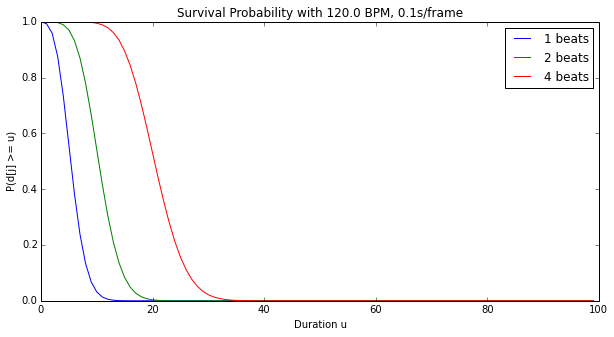

In [190]:
# For one beat let's plot the survival distribution, and keep 95%
U = np.arange(100)
for beats in [1, 2, 4]:
    dur_model = PoissonDM(beats*bench1.frames_per_beat()) # 2 beats
    survival = [dur_model.get_survival(u) for u in U]
    plt.plot(U, survival, label='{} beats'.format(beats))
plt.xlabel('Duration u')
plt.title('Survival Probability with {} BPM, {}s/frame'.format(
    np.mean(bench1.bpm), bench1.frame_sec))
plt.ylabel('P(d[j] >= u)')
plt.legend()

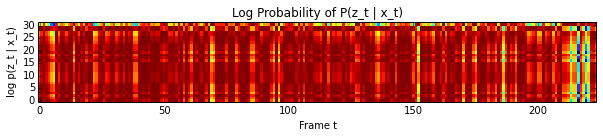

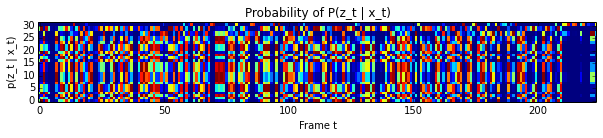

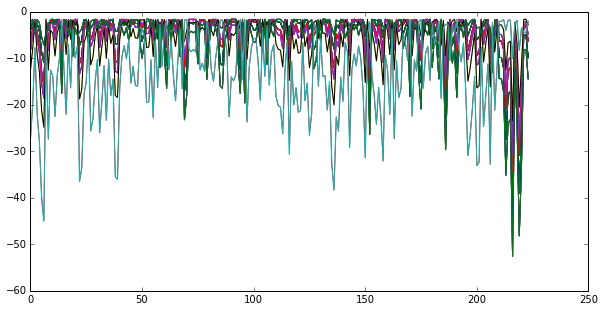

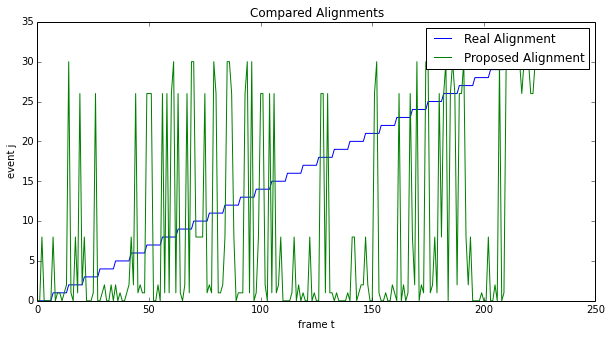

In [141]:
# How good is the observation model by itself?
plt.imshow(linear_hsmm.logobs.T, interpolation='nearest', origin='lower')
plt.title('Log Probability of P(z_t | x_t)')
plt.xlabel('Frame t')
plt.ylabel('log p(z_t | x_t)')
plt.figure()
plt.imshow(np.exp(linear_hsmm.logobs.T), interpolation='nearest', origin='lower')
plt.title('Probability of P(z_t | x_t)')
plt.xlabel('Frame t')
plt.ylabel('p(z_t | x_t)')
plt.figure()
plt.plot(linear_hsmm.logobs)
plt.figure()
plot_aligns(linear_hsmm.logobs.argmax(axis=1), benchmark.z)

Biased Duration Model (Wrong Tempo Assumption)
----

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:93: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:66: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log




hmm offline-viterbi, [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 9, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 13, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 24, 25, 25, 25, 25, 25, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31]

Alignment Stats ('std', 0.079036771344038123)
('max', 0.30000000000000004)
('> 1 s', 0.0)
('> 100 ms', 0.17857142857142858)
('mean', 0.07

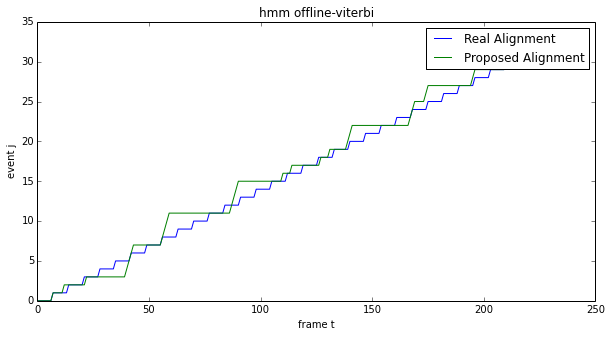

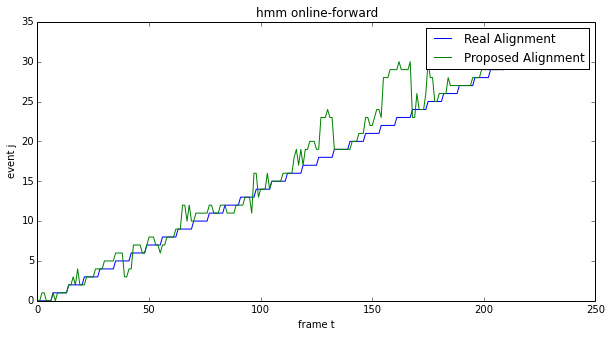

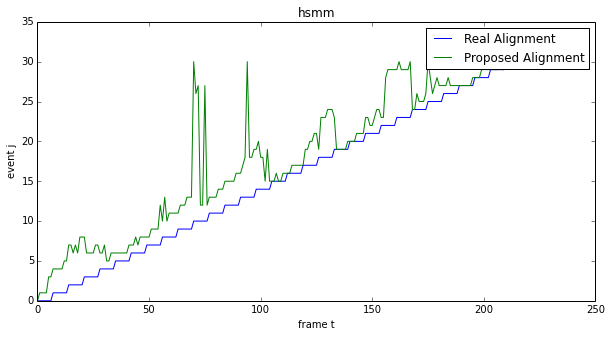

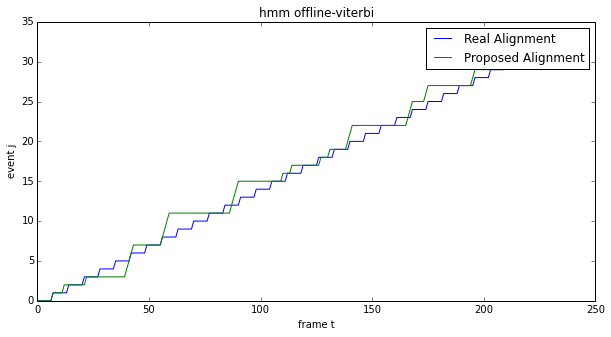

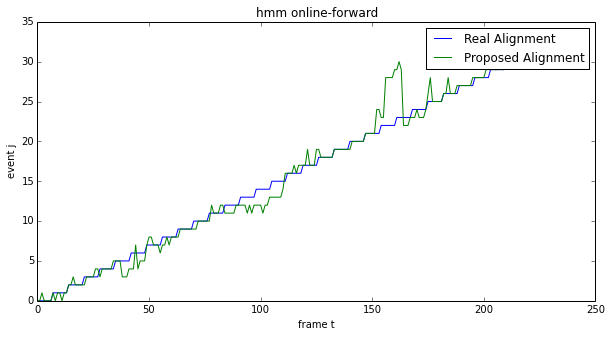

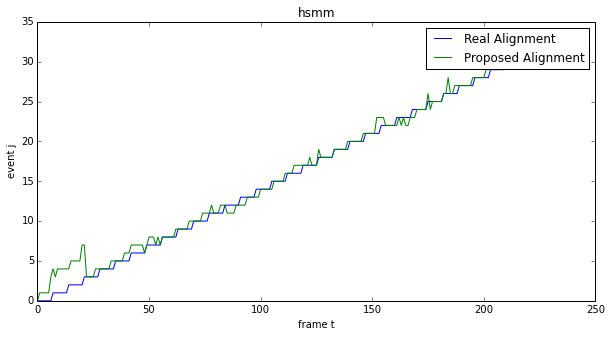

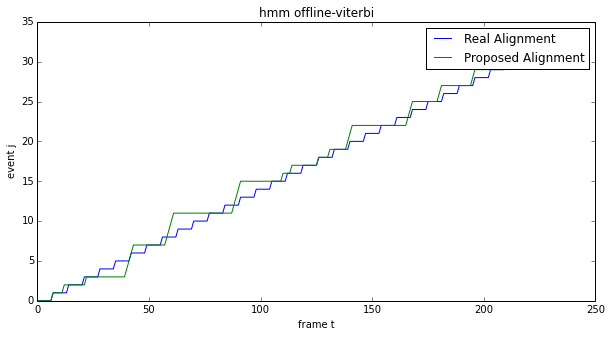

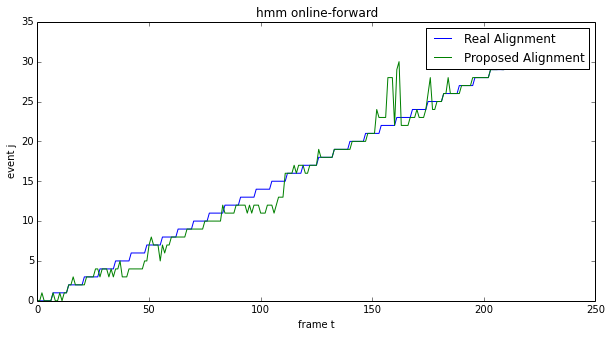

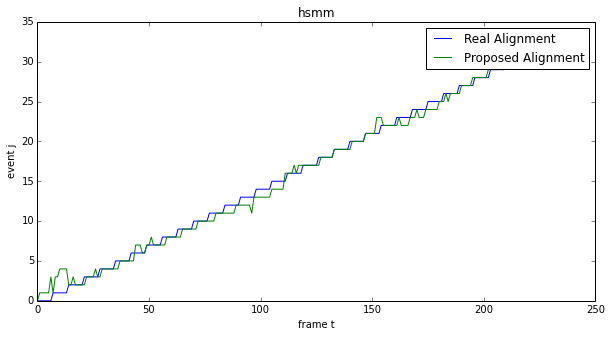

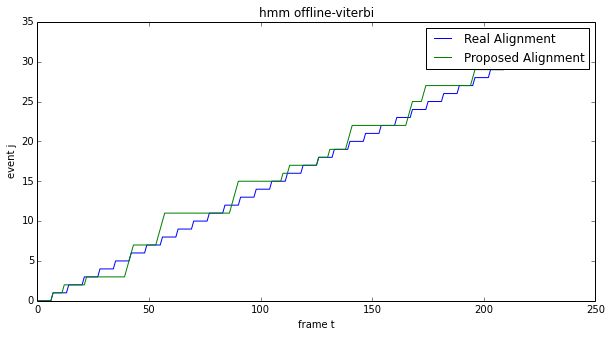

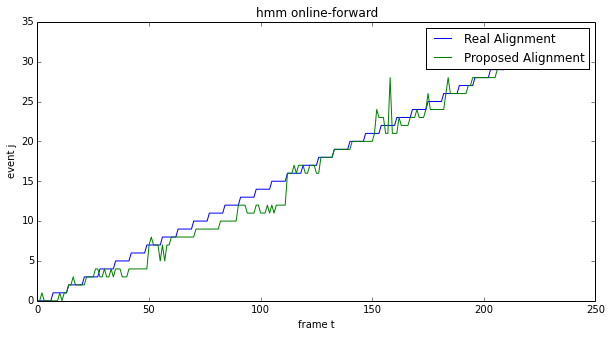

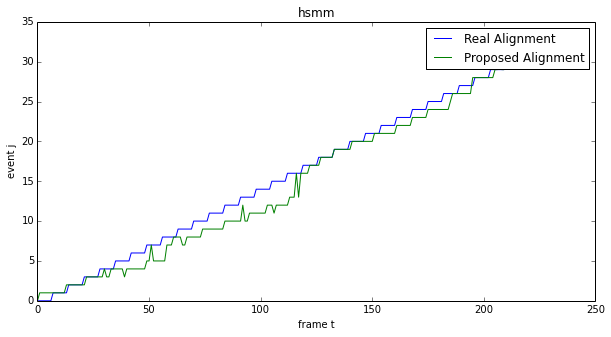

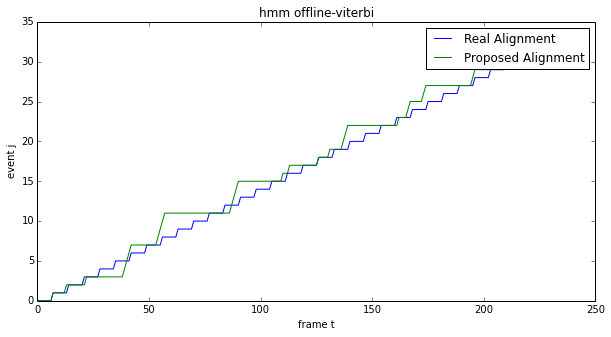

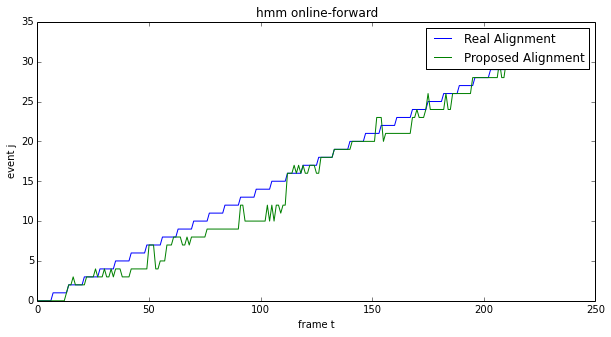

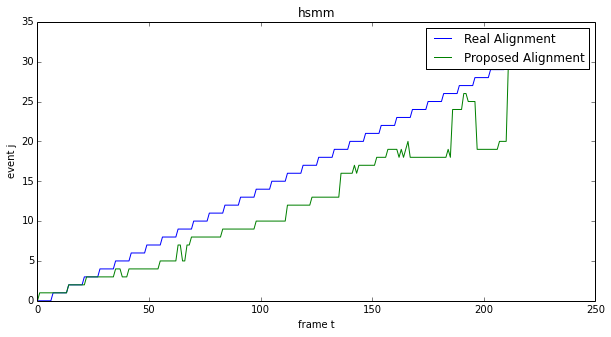

In [187]:
all_predicted = {}
benchmark = bench2

for tempo_scaling in [0.5, 0.8, 1., 1.4, 2.]:
    # Fixed tempo - Duration models will be based on this
    fixed_frames_per_beat = tempo_scaling * np.mean(benchmark.frames_per_beat())    

    predicted_zs = {}

    # Observation Model
    std = 2.
    obs_model = [UnimodalGaussian(pitch, std) for pitch, __ in benchmark.events]


    # Duration Model (for HSMM)
    #dur_model = [GeometricDM(mean=duration*benchmark.frames_per_beat()) for __, duration in benchmark.events]
    dur_model = [PoissonDM(mean=duration*fixed_frames_per_beat) for __, duration in benchmark.events]

    linear_hmm = LinearHMM(benchmark.events, obs_model, fixed_frames_per_beat)
    predicted_zs['hmm offline-viterbi'] = linear_hmm.decode(benchmark.x, mode='offline-viterbi')
    #predicted_zs['hmm online-viterbi'] = linear_hmm.decode(benchmark.x, mode='online-viterbi')
    predicted_zs['hmm online-forward'] = linear_hmm.decode(benchmark.x, mode='online-forward')

    linear_hsmm = LinearHSMM(benchmark.events, obs_model, dur_model)
    predicted_zs['hsmm'] = linear_hsmm.decode(benchmark.x, max_duration=60)

    for model_name, predicted_z in predicted_zs.iteritems():
        print '\n\n{}, {}\n'.format(model_name, predicted_z)
        plot_aligns(predicted_z, benchmark.z)
        plt.title(model_name)
        print 'Alignment Stats', '\n'.join(map(str, 
            evaluate(predicted_z, benchmark.z, benchmark.frame_sec).items()))
        plt.figure()
        
    all_predicted[tempo_scaling] = predicted_zs

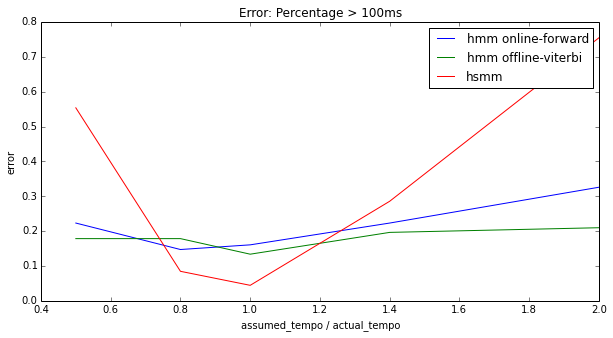

In [188]:
def get_error(predicted_z, attr='> 100 ms'):
    return evaluate(predicted_z, 
             benchmark.z, benchmark.frame_sec)[attr]

for model_name in ['hmm online-forward', 'hmm offline-viterbi', 'hsmm']:
    frames, errors = zip(*sorted([(scaling, get_error(predicted_zs[model_name]))
     for scaling, predicted_zs  in all_predicted.items()]))
    plt.plot(frames, errors, label=model_name)
    plt.xlabel('assumed_tempo / actual_tempo')
    plt.ylabel('error')
plt.title('Error: Percentage > 100ms')
plt.legend()

In [172]:
all_predicted[2.0]

{'hmm online-forward': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  2,  3,
         2,  2,  2,  2,  2,  3,  3,  3,  3,  4,  3,  3,  3,  4,  3,  3,  4,
         3,  4,  4,  4,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  7,
         7,  7,  4,  4,  5,  5,  5,  7,  7,  7,  8,  8,  8,  8,  7,  7,  8,
         7,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9, 12, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 12, 10, 12, 10, 12, 12, 11, 12, 12, 16, 16, 16, 17, 16, 17, 16,
        17, 16, 16, 17, 17, 17, 16, 16, 18, 18, 18, 18, 18, 18, 19, 19, 19,
        19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23,
        23, 23, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 23, 23,
        24, 23, 23, 23, 24, 26, 24, 24, 24, 24, 24, 24, 24, 26, 24, 24, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 30, 28, 28, 30, 30, 30, 30, 30, 30, 30, 30, 30